<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

### Preprocessing

In [1]:
# Imports
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [2]:
# set data path
path = './data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'

In [7]:
# Gensim preprocessing
ex_str = "this is an example of Gensim simple_preprocess utility function."

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short
CUSTOM_FILTERS = [lambda x: x.lower(),         # Lowercase
                  strip_multiple_whitespaces,  # Remove repeating white space
                  strip_numeric,               # Remove numbers
                  remove_stopwords,            # Remove stopwords
                  strip_non_alphanum,          # Remove non-alpha numeric characters,
                  strip_short                  # Remove words less than 3 characters long
                  ]
# Preprocess text with custom filters
preprocess_string(ex_str, CUSTOM_FILTERS)

['example', 'gensim', 'simple_preprocess', 'utility', 'function']

In [68]:
# create a custom stopwords list
STOPWORDS = set(STOPWORDS).union(set(['amazon', 'tablet', 'kindl', 'batteri']))

# simple tokenizer
def tokenize(text):
    return [token for token in preprocess_string(text) if token not in STOPWORDS]

In [10]:
df = pd.read_csv(path)

In [11]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


### Tokenize and get a count

In [17]:
# make a new df with the desired columns from the data
reviews_df = df[['reviews.rating', 'reviews.text']].copy()
reviews_df.head()

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


In [69]:
reviews_df['tokenized_text'] = reviews_df['reviews.text'].apply(lambda text: tokenize(text))
reviews_df.head()

,reviews.rating,reviews.text,tokenized_text
0,3,I order 3 of them and one of the item is bad q...,"[order, item, bad, qualiti, miss, backup, spri..."
1,4,Bulk is always the less expensive way to go fo...,"[bulk, expens, wai, product, like]"
2,5,Well they are not Duracell but for the price i...,"[duracel, price, happi]"
3,5,Seem to work as well as name brand batteries a...,"[work, brand, better, price]"
4,5,These batteries are very long lasting the pric...,"[long, price, great]"


In [25]:
from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts of words in the document set.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [70]:
wc = count(reviews_df['tokenized_text'])
print(wc.shape)
wc.head(10)

(6461, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
21,great,8192,9466,1.0,0.033938,0.033938,0.289143
81,love,5548,6232,2.0,0.022343,0.056281,0.195821
29,good,5232,5917,3.0,0.021214,0.077495,0.184668
16,price,5160,5495,4.0,0.019701,0.097196,0.182126
4,work,4254,4635,5.0,0.016618,0.113814,0.150148
30,bought,2980,3186,6.0,0.011423,0.125237,0.105181
162,kid,2441,3019,7.0,0.010824,0.136061,0.086157
712,easi,2705,2957,8.0,0.010602,0.146662,0.095475
10,like,2506,2885,9.0,0.010343,0.157006,0.088451
32,bui,2518,2808,10.0,0.010067,0.167073,0.088875


### Set up LDA Topic Modeling

In [71]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(reviews_df['tokenized_text'])

In [73]:
id2word.token2id['bought']

25

In [74]:
# remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [75]:
corpus = [id2word.doc2bow(text) for text in reviews_df['tokenized_text']]

In [76]:
corpus[5]

[(18, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 2),
 (35, 1),
 (36, 1)]

In [77]:
# Initailize the LDA
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42,
                   num_topics = 15,
                   passes=10,
                   workers=12
                  )

In [78]:
lda.print_topics()

[(0,
  '0.033*"app" + 0.030*"book" + 0.027*"read" + 0.023*"store" + 0.022*"like" + 0.018*"good" + 0.018*"ipad" + 0.017*"googl" + 0.014*"pretti" + 0.013*"android"'),
 (1,
  '0.115*"great" + 0.043*"easi" + 0.036*"movi" + 0.031*"watch" + 0.028*"game" + 0.028*"work" + 0.023*"download" + 0.022*"app" + 0.022*"kid" + 0.022*"read"'),
 (2,
  '0.030*"like" + 0.021*"good" + 0.021*"screen" + 0.021*"plai" + 0.020*"game" + 0.019*"old" + 0.019*"year" + 0.019*"better" + 0.017*"ipad" + 0.016*"bought"'),
 (3,
  '0.127*"love" + 0.055*"old" + 0.051*"bought" + 0.051*"year" + 0.038*"great" + 0.031*"gift" + 0.029*"easi" + 0.024*"christma" + 0.024*"kid" + 0.022*"daughter"'),
 (4,
  '0.041*"light" + 0.020*"read" + 0.015*"love" + 0.014*"purchas" + 0.013*"easi" + 0.012*"weight" + 0.012*"case" + 0.012*"charg" + 0.011*"devic" + 0.011*"reader"'),
 (5,
  '0.039*"screen" + 0.026*"read" + 0.022*"size" + 0.021*"like" + 0.012*"easi" + 0.011*"easier" + 0.010*"light" + 0.010*"need" + 0.009*"good" + 0.009*"button"'),
 (6,


In [79]:
# print the topics neatly
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
app book read store like

------ Topic 1 ------
great easi movi watch game

------ Topic 2 ------
like good screen plai game

------ Topic 3 ------
love old bought year great

------ Topic 4 ------
light read love purchas easi

------ Topic 5 ------
screen read size like easi

------ Topic 6 ------
good price great valu product

------ Topic 7 ------
great easi nice featur size

------ Topic 8 ------
purchas app son enjoi love

------ Topic 9 ------
read game plai love book

------ Topic 10 ------
work great price long brand

------ Topic 11 ------
bought want time work read

------ Topic 12 ------
kid app game love time

------ Topic 13 ------
great product price love work

------ Topic 14 ------
bui best price purchas bought



### Topic Distance Visualization

In [80]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [81]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.195176  0.031779       1        1  12.798938
14    -0.179745  0.028521       2        1   9.926500
3      0.173973  0.089546       3        1   9.121759
6     -0.135810  0.186619       4        1   7.557361
12     0.172307  0.037397       5        1   7.465176
5     -0.089565 -0.180561       6        1   6.993219
7     -0.033016  0.011801       7        1   6.692118
4     -0.059530 -0.133070       8        1   6.188211
0     -0.009073 -0.055354       9        1   5.632322
9      0.141003 -0.045874      10        1   5.130524
2      0.045367 -0.037702      11        1   4.935910
1      0.066153  0.077159      12        1   4.930235
13    -0.019852  0.076170      13        1   4.315946
11     0.022902 -0.047695      14        1   4.313211
8      0.100062 -0.038735      15        1   3.998574, topic_info=        Term         Freq        Total Category  logprob  loglift
19     great  8909.000000  8909.000000  Default  30.0000  30.0000
76      love  5943.000000  5943.000000  Default  29.0000  29.0000
30      good  5452.000000  5452.000000  Default  28.0000  28.0000
12   product  2290.000000  2290.000000  Default  27.0000  27.0000
16     price  4997.000000  4997.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
231     case    64.566322   930.708557  Topic15  -5.1245   0.5510
11      like    74.985138  2915.577393  Topic15  -4.9749  -0.4413
349     plai    68.729218  1766.472290  Topic15  -5.0620  -0.0273
189    devic    66.299393  1461.095825  Topic15  -5.0980   0.1265
154      kid    68.011574  3198.082275  Topic15  -5.0725  -0.6314

[1162 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
51        1  0.351730     aaa
51        2  0.470208     aaa
51        4  0.048132     aaa
51        6  0.014810     aaa
51        8  0.103668     aaa
...     ...       ...     ...
1667     14  0.021118  youtub
1667     15  0.005279  youtub
926       2  0.841940     yup
2017      6  0.910611  zipper
1201     14  0.927047    zone

[4675 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 15, 4, 7, 13, 6, 8, 5, 1, 10, 3, 2, 14, 12, 9])

### Selecting Optimal Number of Topics 

In [84]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        print(f'PASS #{iter_}:')
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
            print(f'Evaluating Topic Model with {num_topics} topics...')

    return coherence_values

In [85]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            start=5, 
                                            limit=40, 
                                            step=3,
                                            passes=5)

PASS #0:
Evaluating Topic Model with 5 topics...
Evaluating Topic Model with 8 topics...
Evaluating Topic Model with 11 topics...
Evaluating Topic Model with 14 topics...
Evaluating Topic Model with 17 topics...
Evaluating Topic Model with 20 topics...
Evaluating Topic Model with 23 topics...
Evaluating Topic Model with 26 topics...
Evaluating Topic Model with 29 topics...
Evaluating Topic Model with 32 topics...
Evaluating Topic Model with 35 topics...
Evaluating Topic Model with 38 topics...
PASS #1:
Evaluating Topic Model with 5 topics...
Evaluating Topic Model with 8 topics...
Evaluating Topic Model with 11 topics...
Evaluating Topic Model with 14 topics...
Evaluating Topic Model with 17 topics...
Evaluating Topic Model with 20 topics...
Evaluating Topic Model with 23 topics...
Evaluating Topic Model with 26 topics...
Evaluating Topic Model with 29 topics...
Evaluating Topic Model with 32 topics...
Evaluating Topic Model with 35 topics...
Evaluating Topic Model with 38 topics...
PA

In [86]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,5,-2.540518
1,0,8,-2.573967
2,0,11,-2.586158
3,0,14,-2.705374
4,0,17,-2.793960


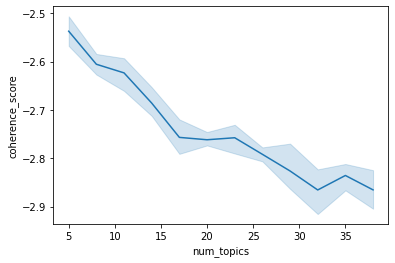

In [87]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling